# Setting

In [1]:
from vivino_community_reviews import save_reviews, load_reviews
from vivino_community_reviews import vivino_reviews, concat_reviews, check_url, check_duplicated, check_wine

/home/lbk/.cache/pypoetry/virtualenvs/scrap2-pSsZr_wz-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import pandas as pd
import time

def read_csv(files, path_data, **kwargs):
    """
    kwargs: keyword args for pd.read_csv
    """
    if not isinstance(files, list):
        files = [x for x in os.listdir(path_data) if x.startswith(files)]

    df_reviews = pd.DataFrame()
    for f in files:
        df = pd.read_csv(f'{path_data}/{f}', **kwargs)
        df_reviews = pd.concat([df_reviews, df])

    return df_reviews.reset_index(drop=True)


import langdetect
import json
from deep_translator import GoogleTranslator
from tqdm import tqdm

def detect_language(text):
    try:
        return langdetect.detect(text)
    except KeyboardInterrupt as e:
        raise(e)
    except:
        return '<-- ERROR -->'


def get_translation(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(str(text))
    except KeyboardInterrupt as e:
        raise(e)
    except:
        return '<-- ERROR -->'


def translate_reviews(df, merge=True):
    df = df.reset_index(drop=True)
    
    tmp_data = []
    for rec in tqdm(df.to_dict('records')):
        tmp_data.append({
            #'wid': rec['wid'],
            'lang': detect_language(rec['review']),
            'review_transl': get_translation(rec['review'])
        })

    df_trans = pd.DataFrame(tmp_data)
    if merge:
        df_trans = df.merge(df_trans, left_index=True, right_index=True)

    return df_trans

# Existing

In [74]:
!unzip -l wine_reviews.zip

Archive:  wine_reviews.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
  2316640  2024-03-19 20:37   wine_reviews_240319e.csv
---------                     -------
  2316640                     1 file


In [75]:
file = 'wine_reviews_2' # exclude wine_reviews_tmp.csv
#file = ['wine_reviews_240319b.csv', 'wine_reviews_240319c.csv', 'wine_reviews_240319d.csv']
#file = ['wine_reviews_240319e.csv']
        
df_reviews = read_csv(file, 'data')
len(df_reviews)

9891

In [76]:
df_reviews.head()

,wid,wine,date,review,source,lang,review_transl,style
0,40,Arione Moscato d'Asti,2023-11-06,pera pesca nota tropicale minerali,vivino,it,pear peach tropical note minerals,sparkling
1,40,Arione Moscato d'Asti,2023-10-17,Ottimo,vivino,it,Optimal,sparkling
2,40,Arione Moscato d'Asti,2023-10-09,"조금 산뜻한 향, 처음 마시고 조금 있는 바디감, Saracco보다 조금 덜 달게 ...",vivino,ko,"A slightly refreshing scent, a bit of body whe...",sparkling
3,40,Arione Moscato d'Asti,2023-10-08,"Afrutado, delicioso.",vivino,es,"Fruity, delicious.",sparkling
4,40,Arione Moscato d'Asti,2023-07-21,honey apple peach citrus Slight fizziness ligh...,vivino,en,honey apple peach citrus Slight fizziness ligh...,sparkling


In [69]:
df_reviews.groupby(['wid', 'wine']).review_transl.count().sort_index(level=0)

wid  wine                                                   
0    Casillero del Diablo Cabernet Sauvignon (Reserva)          472
1    Yellow Tail Cabernet Sauvignon                             136
2    Roche Mazet Cuvée Spéciale Cabernet Sauvignon               61
3    San Pedro Gato Negro Cabernet Sauvignon                    878
4    Aguirre Dos Copas Cabernet Sauvignon                         7
                                                               ... 
64   Dark Horse Cabernet Sauvignon                              275
65   14 Hands Cabernet Sauvignon                                106
66   Quebrada de Macul Alba de Domus                             28
67   Montes Montes Alpha Special Cuvée Cabernet Sauvignon        37
68   Masseria Borgo dei Trulli Lucale Appassimento Primitivo     63
Name: review_transl, Length: 69, dtype: int64

In [6]:
df_reviews.wid.nunique()

69

In [7]:
id_start = df_reviews.wid.max() + 1
id_start

69

In [8]:
# wid missing
mwid = set(range(df_reviews.wid.max())) - set(df_reviews.wid.unique())
mwid = list(mwid)
mwid

[]

## Check duplicates

In [9]:
check_duplicated(df_reviews)

,wid,wine,date,review,source,lang,review_transl


*uncomment if duplicates exist*

In [77]:
df_reviews = check_duplicated(df_reviews, drop=True)

In [78]:
len(df_reviews)

173

# Scraping

## Wines

In [12]:
from wine_scrapers import simple_scraper

In [13]:
url = 'https://www.gsshop.com/shop/wine/plan.gs?planSeq=175966&planType=R&lseq=424328-5'
wines, _ = simple_scraper(url, 'prd-name', 'prd-desc')

In [14]:
ws = dict(zip(wines['prd-name'], wines['prd-desc']))
ws

{'몬테스)알파 블랙 카버네소비뇽': 'Montes Alpha Black C/S',
 '카니버 카버네 소비뇽': 'CARNIVOR CABERNET SAUVIGNON',
 '킬리카눈 코브넌트 쉬라즈': 'KILIKANOON COVENANT SHIRAZ',
 '투 핸즈)엔젤스 쉐어 쉬라즈': "Two Hands Angel's Share",
 '디아블로)블랙 카베르네 소비뇽': 'DIABLO BLACK CABERNET SAUVIGNON',
 '카를로 사니 수수마니엘로': 'Carlo Sani, Susumaniello',
 '다렌버그 하이 트렐리스 카베르네 소비뇽': 'The High Trellis Cabernet Sauvignon',
 '보데가스 란 그란 리제르바': 'BODEGAS LAN GRAN RESERVA',
 '포스타 레드와인(2입)': 'Four Star Red',
 '우드브릿지 까베르네 소비뇽': 'Woodbridge Cabernet Sauvignon',
 '까테나 자파타)까테나 까베르네소비뇽': 'Catena Zapata Catena Cabernet Sauvignon',
 '우나니메)피노누아': 'UNANIME PINOT NOIR',
 '끌로 드 로스 씨에떼': 'Clos de Los Siete',
 '필리프 수퍼 토스카나(선물추천)': 'Philip (Super Toscana)',
 '라포스톨)그랑 셀렉션 메를로': 'Lapostolle Merlot',
 '델리카토)1924 포트 배럴 에이지드 피노누아': '1924 Port Barrel Aged Pinot Noir',
 '코폴라)다이아컬렉션 클라렛': 'Coppola-Diamond Collection Claret',
 '다크호스 카버네 소비뇽': 'DARK HORSE CABERNET SAUVIGNON',
 '14 핸즈 카베르네 소비뇽': '14Hands Cabernet Sauvignon',
 '알바 드 도머스': 'Alba de Domus',
 '파이오니어스 포인트 까베르네 소비뇽': "Pionee

In [15]:
ws['몬테스)알파 블랙 카버네소비뇽'] = 'Montes Montes Alpha Special Cuvée Cabernet Sauvignon'
ws['루칼레 아파씨멘토'] = 'Lucale Appassimento'
ws

{'몬테스)알파 블랙 카버네소비뇽': 'Montes Montes Alpha Special Cuvée Cabernet Sauvignon',
 '카니버 카버네 소비뇽': 'CARNIVOR CABERNET SAUVIGNON',
 '킬리카눈 코브넌트 쉬라즈': 'KILIKANOON COVENANT SHIRAZ',
 '투 핸즈)엔젤스 쉐어 쉬라즈': "Two Hands Angel's Share",
 '디아블로)블랙 카베르네 소비뇽': 'DIABLO BLACK CABERNET SAUVIGNON',
 '카를로 사니 수수마니엘로': 'Carlo Sani, Susumaniello',
 '다렌버그 하이 트렐리스 카베르네 소비뇽': 'The High Trellis Cabernet Sauvignon',
 '보데가스 란 그란 리제르바': 'BODEGAS LAN GRAN RESERVA',
 '포스타 레드와인(2입)': 'Four Star Red',
 '우드브릿지 까베르네 소비뇽': 'Woodbridge Cabernet Sauvignon',
 '까테나 자파타)까테나 까베르네소비뇽': 'Catena Zapata Catena Cabernet Sauvignon',
 '우나니메)피노누아': 'UNANIME PINOT NOIR',
 '끌로 드 로스 씨에떼': 'Clos de Los Siete',
 '필리프 수퍼 토스카나(선물추천)': 'Philip (Super Toscana)',
 '라포스톨)그랑 셀렉션 메를로': 'Lapostolle Merlot',
 '델리카토)1924 포트 배럴 에이지드 피노누아': '1924 Port Barrel Aged Pinot Noir',
 '코폴라)다이아컬렉션 클라렛': 'Coppola-Diamond Collection Claret',
 '다크호스 카버네 소비뇽': 'DARK HORSE CABERNET SAUVIGNON',
 '14 핸즈 카베르네 소비뇽': '14Hands Cabernet Sauvignon',
 '알바 드 도머스': 'Alba de Domus',
 

In [16]:
wines = list(ws.values())

In [18]:
wid_wine = df_reviews.drop_duplicates(['wid', 'wine'])[['wid', 'wine']].to_dict(orient='list')
wid_list = []
print_list = []

for i, w in enumerate(wines):
    idx, sc = check_wine(w, wid_wine['wine'], print_result=False)
    wn = wid_wine['wine'][idx]
    wid = wid_wine['wid'][idx]
    wid_list.append(wid)
    p = f'{i}) {w}: score {sc:.2f} with {wn}'
    print(p)
    print_list.append(p)

0) Montes Montes Alpha Special Cuvée Cabernet Sauvignon: score 0.95 with Montes Montes Alpha Cabernet Sauvignon
1) CARNIVOR CABERNET SAUVIGNON: score 1.00 with Carnivor Cabernet Sauvignon
2) KILIKANOON COVENANT SHIRAZ: score 1.00 with Kilikanoon Covenant Shiraz
3) Two Hands Angel's Share: score 0.75 with Two Hands Angels' Share Shiraz
4) DIABLO BLACK CABERNET SAUVIGNON: score 1.00 with Diablo Black Cabernet Sauvignon
5) Carlo Sani, Susumaniello: score 0.96 with Carlo Sani Susumaniello
6) The High Trellis Cabernet Sauvignon: score 0.91 with d'Arenberg The High Trellis Cabernet Sauvignon
7) BODEGAS LAN GRAN RESERVA: score 0.77 with Lan Gran Reserva Rioja
8) Four Star Red: score 0.32 with Yellow Tail Chardonnay
9) Woodbridge Cabernet Sauvignon: score 0.90 with Woodbridge by Robert Mondavi Cabernet Sauvignon
10) Catena Zapata Catena Cabernet Sauvignon: score 0.91 with Catena Cabernet Sauvignon
11) UNANIME PINOT NOIR: score 0.76 with Bread & Butter Pinot Noir
12) Clos de Los Siete: score 0.

In [19]:
# review candidate wines before scraping
"""
Montes Montes Alpha black is Special Cuvée
Four Star Red: no recent reviews
UNANIME PINOT NOIR is Mascota Vineyards Unánime Pinot Noir which is in db
Pioneer's Point: no enough ratings
"""

idx = [0, 8, 11, 20, 21, 22]
_ = [print(print_list[x]) for x in idx]

0) Montes Montes Alpha Special Cuvée Cabernet Sauvignon: score 0.95 with Montes Montes Alpha Cabernet Sauvignon
8) Four Star Red: score 0.32 with Yellow Tail Chardonnay
11) UNANIME PINOT NOIR: score 0.76 with Bread & Butter Pinot Noir
20) Pioneer's Point Cabernet Sauvignon: score 0.82 with Kendall-Jackson Vintner's Reserve Cabernet Sauvignon
21) Lucale Appassimento: score 0.41 with Balbi Soprani Moscato d'Asti
22) Tarima Hill: score 0.43 with William Hill North Coast Chardonnay


In [28]:
name = 'Volver'
df_reviews.loc[df_reviews.wine.str.contains(name)]

,wid,wine,date,review,source,lang,review_transl


In [ ]:
#df_reviews.loc[df_reviews.wid.isin(wid_list)][['wid', 'wine']].drop_duplicates()

### Check URL

In [29]:
file = 'data/wines_to_collect.txt'

with open(file, 'r') as f:
    w = f.read()
print(w)

Montes Montes Alpha Special Cuvée Cabernet Sauvignon
https://www.vivino.com/montes-casablanca-valley-montes-alpha-special-cuvee-cabernet-sauvignon-colchagua-valley/w/5006161
Masseria Borgo dei Trulli Lucale Appassimento Primitivo
https://www.vivino.com/masseria-borgo-dei-trulli-lucale-appassimento-primitivo/w/4972078?ref=nav-search
Volver Tarima Hill Old Vines Monastrell
https://www.vivino.com/tarima-tarima-hill-old-vines-monastrell/w/1603076?ref=nav-search#all_reviews



In [30]:
w = w.strip('\n').split('\n')
wines = {w[i]:w[i+1] for i in range(0, len(w), 2)}
len(wines)

3

In [31]:
# check if wine name and its url match or not
df = check_url(wines)

The top 5 pairs of least similarity:
0.74) Montes Montes Alpha Special Cuvée Cabernet Sauvignon: montes-casablanca-valley-montes-alpha-special-cuvee-cabernet-sauvignon-colchagua-valley
0.76) Volver Tarima Hill Old Vines Monastrell: tarima-tarima-hill-old-vines-monastrell
0.90) Masseria Borgo dei Trulli Lucale Appassimento Primitivo: masseria-borgo-dei-trulli-lucale-appassimento-primitivo


## Setting

In [35]:
locator_ratings = "//a[@href='#all_reviews']"
locator_more = "//button[@tabindex='0']"
locator_recent = '//*[@data-testid="baseModalBackdrop"]/div[2]/div[2]/div[2]/div/a[1]'

locator_review = "communityReview__reviewText--2bfLj"
locator_date = "anchor_anchor__m8Qi- reviewAnchor__anchor--2NKFw reviewDate__reviewDate--49vpM undefined"

kwargs = {
    'loc1': locator_ratings,
    'loc2': locator_more,
    'loc3': locator_recent, 
    'loc4': locator_review,
    'loc5': locator_date
}

In [36]:
kwargs.update({
    'end_date': '20220101',
    'source': 'vivino',
    #'headless': True, # failed for background running 
    #'max_scr': 10, 'time_scr': 2, 'check_idx': 4
})

## Collect

**load if the reviews of the wines not translated yet**

In [ ]:
files = []
#files = ['wine_50', 'wine_51', 'wine_52', 'wine_53', 'wine_54']
#files = [f'wine_{i}' for i in range(50,64)]
path = 'data'

df_reviews = pd.DataFrame()
for f in files:
    df = load_reviews(f'{f}.csv', path=path)
    df_reviews = pd.concat([df_reviews, df])

# check duplicate wid
df_reviews.groupby('wid').wine.unique()

In [34]:
#id_start = df_reviews.wid.max() + 1
#id_start

67

*uncomment if no reviews unfinished*

In [37]:
df_reviews = pd.DataFrame()

In [38]:
num_try = 1 # num of try to scrape for failed wines

col_rev = ['wid', 'wine', 'date', 'review', 'source']
path = 'data'
wines_failed = dict()

for i in range(num_try):
    print(f'scraping {i+1}', '*'*20)
    #for wine_name, wine_url in wines:
    for wine_name, wine_url in wines.items():
        try:
            df = vivino_reviews(wine_url, wine_name, **kwargs)
            df_reviews = concat_reviews(df_reviews, df, wine_name, col_rev, path=path, id_start=id_start)
        except:
            print(f'ERROR: check {wine_name}')
            wines_failed.update({wine_name: wine_url})
        time.sleep(3)

    if len(wines_failed) > 0:
        print(f'num of failed: {len(wines_failed)}\n')
        wines = wines_failed
        wines_failed = dict()
        time.sleep(3)
    else:
        break

scraping 1 ********************


43it [00:33,  1.29it/s]


Montes Montes Alpha Special Cuvée Cabernet Sauvignon: 43 reviews collected.
data/wine_67.csv saved.


73it [00:55,  1.33it/s]


Masseria Borgo dei Trulli Lucale Appassimento Primitivo: 73 reviews collected.
data/wine_68.csv saved.


83it [01:30,  1.09s/it]


Volver Tarima Hill Old Vines Monastrell: 83 reviews collected.
data/wine_69.csv saved.


In [39]:
df_reviews

,wid,wine,date,review,source
0,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-03-14,"Vinho muito, mas muito bom da excelente vinícu...",vivino
1,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-01-20,oak tobacco black fruit blackberry pepper smok...,vivino
2,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-01-11,Adoramos! Frutas vermelhas. Ameixa. Pimentão v...,vivino
3,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2023-12-17,Boda en SMA Clau y Polo,vivino
4,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2023-12-02,Gedronken bij Marcel en Marius. Qua smaakprofi...,vivino
...,...,...,...,...,...
78,69,Volver Tarima Hill Old Vines Monastrell,2021-12-01,가성비 굿,vivino
79,69,Volver Tarima Hill Old Vines Monastrell,2021-11-14,"In the Cambrian probiert. Sehr intensiv, schwe...",vivino
80,69,Volver Tarima Hill Old Vines Monastrell,2020-05-09,Deep purple full bodied wine with notes of plu...,vivino
81,69,Volver Tarima Hill Old Vines Monastrell,2023-07-24,"Medium Body, Black Peppers, Licorice, chocolat...",vivino


**temp saving before translation**

In [40]:
df_reviews.groupby(['wid', 'wine']).review.count().sort_index(level=0)

wid  wine                                                   
67   Montes Montes Alpha Special Cuvée Cabernet Sauvignon       43
68   Masseria Borgo dei Trulli Lucale Appassimento Primitivo    73
69   Volver Tarima Hill Old Vines Monastrell                    83
Name: review, dtype: int64

In [41]:
save_reviews(df_reviews, 'wine_reviews_tmp.csv', 'data', overwrite=True)

data/wine_reviews_tmp.csv saved.


# Review data

In [67]:
df_reviews = load_reviews('wine_reviews_tmp.csv', 'data')

data/wine_reviews_tmp.csv loaded.


In [68]:
cond = (df_reviews.date.isna()) | (df_reviews.review.isna())
df_reviews.loc[cond]

,wid,wine,date,review,source
40,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2020-07-25,NaN,vivino
101,68,Masseria Borgo dei Trulli Lucale Appassimento ...,2022-01-29,NaN,vivino
113,68,Masseria Borgo dei Trulli Lucale Appassimento ...,2022-02-17,NaN,vivino
184,69,Volver Tarima Hill Old Vines Monastrell,2022-01-29,NaN,vivino
191,69,Volver Tarima Hill Old Vines Monastrell,2021-12-26,NaN,vivino


In [69]:
df_reviews = df_reviews.loc[~cond].reset_index(drop=True)

In [70]:
df_reviews.date.dt.year.value_counts().sort_index(ascending=False)

date
2024    26
2023    75
2022    75
2021    15
2020     2
2019     1
Name: count, dtype: int64

In [71]:
kwargs['end_date']

'20220101'

In [72]:
df_reviews = df_reviews.loc[df_reviews.date >= kwargs['end_date']]

<Axes: >

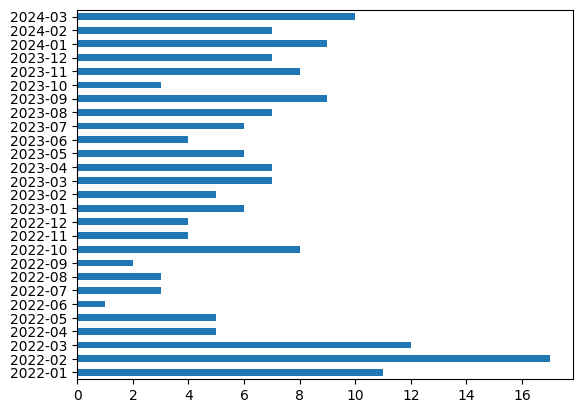

In [73]:
#d = df_reviews.date.agg(['min', 'max']).to_list()
d = [kwargs['end_date'], df_reviews.date.max()]

date_range = pd.date_range(start=d[0], end=d[1]).to_period("M").unique()

(df_reviews
 .set_index('date').to_period("M")
 .groupby(level=0).review.count()
 .sort_index()
 .reindex(date_range, fill_value=0)
 .plot(kind='barh')
)

<Axes: ylabel='wine'>

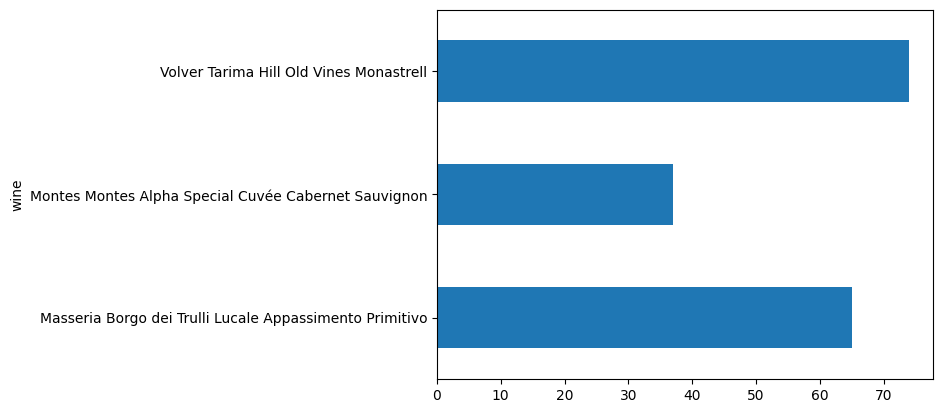

In [74]:
(df_reviews
 .groupby(by='wine').review.count()
 .plot(kind='barh')
)

In [75]:
df_reviews.head()

,wid,wine,date,review,source
0,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-03-14,"Vinho muito, mas muito bom da excelente vinícu...",vivino
1,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-01-20,oak tobacco black fruit blackberry pepper smok...,vivino
2,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-01-11,Adoramos! Frutas vermelhas. Ameixa. Pimentão v...,vivino
3,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2023-12-17,Boda en SMA Clau y Polo,vivino
4,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2023-12-02,Gedronken bij Marcel en Marius. Qua smaakprofi...,vivino


[Check duplicates](#Check-duplicates)

## Wine ID

In [79]:
df_reviews

,wid,wine,date,review,source
0,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-03-14,"Vinho muito, mas muito bom da excelente vinícu...",vivino
1,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-01-20,oak tobacco black fruit blackberry pepper smok...,vivino
2,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-01-11,Adoramos! Frutas vermelhas. Ameixa. Pimentão v...,vivino
3,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2023-12-17,Boda en SMA Clau y Polo,vivino
4,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2023-12-02,Gedronken bij Marcel en Marius. Qua smaakprofi...,vivino
...,...,...,...,...,...
181,69,Volver Tarima Hill Old Vines Monastrell,2022-01-20,"Vino espectacular, 14 meses en barrica frances...",vivino
182,69,Volver Tarima Hill Old Vines Monastrell,2022-01-15,"Dry, Dark, Bold with great flavor",vivino
183,69,Volver Tarima Hill Old Vines Monastrell,2022-01-10,Muy bueno,vivino
184,69,Volver Tarima Hill Old Vines Monastrell,2022-01-10,A very flavorful wine it also has a very nice ...,vivino


In [80]:
file = 'wine_reviews_2' # exclude wine_reviews_tmp.csv
df_reviews_db = read_csv(file, 'data')
len(df_reviews_db)

9718

In [81]:
set(range(df_reviews_db.wid.max()+1)) - set(df_reviews_db.wid.unique())

{41}

In [82]:
wid_f, wid_t = 69, 41

In [83]:
df_reviews.loc[df_reviews.wid == wid_f, 'wid'] = wid_t

In [84]:
df_reviews.groupby('wid').wine.count()

wid
41    73
67    37
68    63
Name: wine, dtype: int64

In [89]:
file_f = f'wine_{wid_f}.csv'
df = read_csv(file_f, 'data')
df['wid'] = wid_t
save_reviews(df, f'wine_{wid_t}.csv', 'data')

data/wine_41.csv saved.


In [91]:
!rm data/{file_f}

## varietal

In [10]:
len(df_reviews)

9891

In [11]:
df_reviews.head()

,wid,wine,date,review,source,lang,review_transl
0,40,Arione Moscato d'Asti,2023-11-06,pera pesca nota tropicale minerali,vivino,it,pear peach tropical note minerals
1,40,Arione Moscato d'Asti,2023-10-17,Ottimo,vivino,it,Optimal
2,40,Arione Moscato d'Asti,2023-10-09,"조금 산뜻한 향, 처음 마시고 조금 있는 바디감, Saracco보다 조금 덜 달게 ...",vivino,ko,"A slightly refreshing scent, a bit of body whe..."
3,40,Arione Moscato d'Asti,2023-10-08,"Afrutado, delicioso.",vivino,es,"Fruity, delicious."
4,40,Arione Moscato d'Asti,2023-07-21,honey apple peach citrus Slight fizziness ligh...,vivino,en,honey apple peach citrus Slight fizziness ligh...


In [12]:
df_reviews.nunique()

wid                69
wine               69
date             1095
review           9500
source              1
lang               41
review_transl    9369
dtype: int64

In [16]:
wid_wine = df_reviews[['wid', 'wine']].drop_duplicates().to_dict(orient='list')
wid_wine['wine']

["Arione Moscato d'Asti",
 "Two Hands Angels' Share Shiraz",
 'Two Hands Gnarly Dudes Shiraz',
 'Two Hands Sexy Beast Cabernet Sauvignon',
 'Cono Sur Single Vineyard Syrah',
 'Cono Sur Single Vineyard Cabernet Sauvignon',
 'Cono Sur Single Vineyard Pinot Noir',
 'Cono Sur Single Vineyard Carmenere',
 'Cono Sur Single Vineyard Chardonnay',
 'Montes Montes Alpha Merlot',
 'Montes Montes Alpha Syrah',
 'San Pedro 1865 Selected Vineyards Syrah',
 'San Pedro 1865 Single Vineyard Malbec',
 'San Pedro 1865 Single Vineyard Syrah',
 'Mollydooker The Boxer Shiraz',
 'William Hill North Coast Cabernet Sauvignon',
 'William Hill North Coast Chardonnay',
 "Kendall-Jackson Vintner's Reserve Chardonnay",
 'Bread & Butter Pinot Noir',
 'Bread & Butter Cabernet Sauvignon',
 'Casillero del Diablo Cabernet Sauvignon (Reserva)',
 'Yellow Tail Cabernet Sauvignon',
 'Roche Mazet Cuvée Spéciale Cabernet Sauvignon',
 'San Pedro Gato Negro Cabernet Sauvignon',
 'Aguirre Dos Copas Cabernet Sauvignon',
 'The 7th

In [26]:
def find_style(name):
    style_dict = {
        'red': ['cabernet', 'shiraz', 'syrah', 'pinot', 'merlot', 'carmenere', 'malbec'],
        'white': ['chardonnay', 'blanc'],
        'sparkling': ['champagne', 'moscato'],
        'desert': []
    }
    style = [s for s, words in style_dict.items() for w in words if w in name.lower()]
    if len(style) == 1:
        return style[0]
    else:
        print('ambiguous')
        return None


#w = 'Mollydooker The Boxer Shira'
#find_style(w)

styles = []
for w in wid_wine['wine']:
    s = find_style(w)
    styles.append(s)

ambiguous
ambiguous
ambiguous
ambiguous
ambiguous
ambiguous
ambiguous
ambiguous
ambiguous
ambiguous
ambiguous


In [29]:
idx = [i for i,s in enumerate(styles) if s is None]
w2 = [wid_wine['wine'][i] for i in idx]
w2

['Cono Sur Single Vineyard Carmenere',
 'San Pedro 1865 Single Vineyard Malbec',
 'Villa M Bianco',
 'Carlo Sani Susumaniello',
 'Lan Gran Reserva Rioja',
 'Clos de los Siete Clos de Los Siete (by Michel Rolland)',
 'Mazzei Philip',
 'Francis Ford Coppola Winery Diamond Collection Claret',
 'Quebrada de Macul Alba de Domus',
 'Masseria Borgo dei Trulli Lucale Appassimento Primitivo',
 'Volver Tarima Hill Old Vines Monastrell']

In [30]:
s2 = ['red', 'red', 'sparkling', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red']
_ = [print(f'{s}: {w}') for w, s in zip(w2, s2)]

red: Cono Sur Single Vineyard Carmenere
red: San Pedro 1865 Single Vineyard Malbec
sparkling: Villa M Bianco
red: Carlo Sani Susumaniello
red: Lan Gran Reserva Rioja
red: Clos de los Siete Clos de Los Siete (by Michel Rolland)
red: Mazzei Philip
red: Francis Ford Coppola Winery Diamond Collection Claret
red: Quebrada de Macul Alba de Domus
red: Masseria Borgo dei Trulli Lucale Appassimento Primitivo
red: Volver Tarima Hill Old Vines Monastrell


In [32]:
for i, x in enumerate(idx):
    styles[x] = s2[i]

[x for x in styles if x is None]

[]

In [58]:
wine_style = dict(zip(wid_wine['wine'], styles))
_ = [print(f'{s}: {w}') for w, s in wine_style.items()]

sparkling: Arione Moscato d'Asti
red: Two Hands Angels' Share Shiraz
red: Two Hands Gnarly Dudes Shiraz
red: Two Hands Sexy Beast Cabernet Sauvignon
red: Cono Sur Single Vineyard Syrah
red: Cono Sur Single Vineyard Cabernet Sauvignon
red: Cono Sur Single Vineyard Pinot Noir
red: Cono Sur Single Vineyard Carmenere
white: Cono Sur Single Vineyard Chardonnay
red: Montes Montes Alpha Merlot
red: Montes Montes Alpha Syrah
red: San Pedro 1865 Selected Vineyards Syrah
red: San Pedro 1865 Single Vineyard Malbec
red: San Pedro 1865 Single Vineyard Syrah
red: Mollydooker The Boxer Shiraz
red: William Hill North Coast Cabernet Sauvignon
white: William Hill North Coast Chardonnay
white: Kendall-Jackson Vintner's Reserve Chardonnay
red: Bread & Butter Pinot Noir
red: Bread & Butter Cabernet Sauvignon
red: Casillero del Diablo Cabernet Sauvignon (Reserva)
red: Yellow Tail Cabernet Sauvignon
red: Roche Mazet Cuvée Spéciale Cabernet Sauvignon
red: San Pedro Gato Negro Cabernet Sauvignon
red: Aguirre D

In [61]:
df_reviews['style'] = df_reviews.apply(lambda x: wine_style[x.wine], axis=1)
df_reviews.head()

,wid,wine,date,review,source,lang,review_transl,style
0,40,Arione Moscato d'Asti,2023-11-06,pera pesca nota tropicale minerali,vivino,it,pear peach tropical note minerals,sparkling
1,40,Arione Moscato d'Asti,2023-10-17,Ottimo,vivino,it,Optimal,sparkling
2,40,Arione Moscato d'Asti,2023-10-09,"조금 산뜻한 향, 처음 마시고 조금 있는 바디감, Saracco보다 조금 덜 달게 ...",vivino,ko,"A slightly refreshing scent, a bit of body whe...",sparkling
3,40,Arione Moscato d'Asti,2023-10-08,"Afrutado, delicioso.",vivino,es,"Fruity, delicious.",sparkling
4,40,Arione Moscato d'Asti,2023-07-21,honey apple peach citrus Slight fizziness ligh...,vivino,en,honey apple peach citrus Slight fizziness ligh...,sparkling


In [63]:
df_reviews.tail()

,wid,wine,date,review,source,lang,review_transl,style
9886,41,Volver Tarima Hill Old Vines Monastrell,2022-01-20,"Vino espectacular, 14 meses en barrica frances...",vivino,es,"Spectacular wine, 14 months in French barrels....",red
9887,41,Volver Tarima Hill Old Vines Monastrell,2022-01-15,"Dry, Dark, Bold with great flavor",vivino,en,"Dry, Dark, Bold with great flavor",red
9888,41,Volver Tarima Hill Old Vines Monastrell,2022-01-10,Muy bueno,vivino,es,Very good,red
9889,41,Volver Tarima Hill Old Vines Monastrell,2022-01-10,A very flavorful wine it also has a very nice ...,vivino,en,A very flavorful wine it also has a very nice ...,red
9890,41,Volver Tarima Hill Old Vines Monastrell,2022-01-08,4.2 풀바디. 적당한 탄닌. 탄산감 없음. 맛있어!,vivino,ko,4.2 Full body. Moderate tannin. No carbonation...,red


# Translate

In [92]:
len(df_reviews)

173

In [93]:
df_reviews.head()

,wid,wine,date,review,source
0,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-03-14,"Vinho muito, mas muito bom da excelente vinícu...",vivino
1,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-01-20,oak tobacco black fruit blackberry pepper smok...,vivino
2,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-01-11,Adoramos! Frutas vermelhas. Ameixa. Pimentão v...,vivino
3,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2023-12-17,Boda en SMA Clau y Polo,vivino
4,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2023-12-02,Gedronken bij Marcel en Marius. Qua smaakprofi...,vivino


In [94]:
df_reviews = translate_reviews(df_reviews)  
df_reviews.head()

100%|█████████████████████████████████████████████████████████████| 173/173 [01:51<00:00,  1.55it/s]


,wid,wine,date,review,source,lang,review_transl
0,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-03-14,"Vinho muito, mas muito bom da excelente vinícu...",vivino,pt,"Very, very good wine from the excellent Montes..."
1,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-01-20,oak tobacco black fruit blackberry pepper smok...,vivino,en,oak tobacco black fruit blackberry pepper smok...
2,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2024-01-11,Adoramos! Frutas vermelhas. Ameixa. Pimentão v...,vivino,pt,We love it! Red fruits. Plum. Red pepper. Coff...
3,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2023-12-17,Boda en SMA Clau y Polo,vivino,cy,Wedding at SMA Clau y Polo
4,67,Montes Montes Alpha Special Cuvée Cabernet Sau...,2023-12-02,Gedronken bij Marcel en Marius. Qua smaakprofi...,vivino,nl,Had drinks with Marcel and Marius. In terms of...


**check translation error**

In [95]:
cond = df_reviews.lang.str.contains('ERROR')
df_reviews.loc[cond]

,wid,wine,date,review,source,lang,review_transl


In [ ]:
df_err = df_reviews.loc[cond].drop(columns=['lang', 'review_transl'])
df_err = translate_reviews(df_err, merge=True)  
df_err

In [76]:
cond_err = df_err.index.isin([1,8,10])
df_err.loc[cond_err]

,wid,wine,date,review,source,lang,review_transl
1,52,Diablo Black Cabernet Sauvignon,2023-06-27,👍,vivino,<-- ERROR -->,None
8,56,Woodbridge by Robert Mondavi Cabernet Sauvignon,2022-11-20,Luísa,vivino,ca,Luisa
10,56,Woodbridge by Robert Mondavi Cabernet Sauvignon,2022-07-17,B2,vivino,de,B2


In [82]:
df_reviews = pd.concat([df_reviews.loc[~cond], df_err.loc[~cond_err]]).reset_index(drop=True)

In [64]:
cond = df_reviews.review_transl.isna()
df_reviews.loc[cond]

,wid,wine,date,review,source,lang,review_transl


In [65]:
df_reviews = df_reviews.loc[~cond]

# save

In [64]:
from datetime import datetime
d = datetime.today().strftime('%y%m%d')
#d = f'{d}b'

file = f'wine_reviews_{d}e.csv'
save_reviews(df_reviews, file)

data/wine_reviews_240319e.csv saved.


In [65]:
#!zip -uj wine_reviews.zip data/{file}
!zip -uj wine_reviews.zip data/wine_reviews_2*e.csv

	zip warning: wine_reviews.zip not found or empty
  adding: wine_reviews_240319e.csv (deflated 72%)


In [66]:
!unzip -l wine_reviews.zip

Archive:  wine_reviews.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
  2316640  2024-03-19 20:37   wine_reviews_240319e.csv
---------                     -------
  2316640                     1 file
